# Import dependencies

In [1]:
# Core libraries
import pandas as pd
import pydotplus

# Data preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

# Machine learning models
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

# Model evaluation metrics
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score

# Visualization tools
from IPython.display import Image, display

In [2]:
# Read the data into data frame.
df = pd.read_csv('data/valentine_gift.csv')
df.head()

,Gender,Age,Relationship_Status,Budget,Occasion,Preference,Relationship_Length,Personal_Interest,Past_Gift_Item,Past_Gift_Reaction,Recent_Purchase_1,Recent_Purchase_2,Recent_Purchase_3,Best_Gift
0,Male,56,Engaged,Low,Just Because,Adventurous,<6 months,Music,Tech Gadget,Loved it,Meal Kit Sub,Gym Membership,Magazine Sub,Fashion Accessory
1,Female,58,Single,Low,Anniversary,Surprise,6-12 months,Technology,Chocolates,Loved it,Phone Charger,Smart Speaker,Processor Chip,Fashion Accessory
2,Female,21,Single,Low,Valentine's Day,Romantic,5+ years,Cooking,Fashion Accessory,Loved it,Magazine Sub,Streaming Sub,Meal Kit Sub,Flowers
3,Other,60,Married,Very High,Anniversary,Sentimental,6-12 months,Music,Chocolates,Loved it,Meal Kit Sub,Gym Membership,Magazine Sub,Personalized Gift
4,Male,56,Engaged,Low,Just Because,Adventurous,<6 months,Music,Tech Gadget,Loved it,Meal Kit Sub,Gym Membership,Magazine Sub,Fashion Accessory


In [3]:
def merge_data(df, column_name, value_one, value_two):
    """
    Merges two similar values into one in a specified column.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        column_name (str): The name of the column to modify.
        value_one: The value to be replaced.
        value_two: The value to replace with.

    Returns:
        None: Modifies the DataFrame in place.
    """
    df[column_name] = df[column_name].replace(value_one, value_two)

def hot_encode(df):
    """
    Applies one-hot encoding to all categorical columns in the DataFrame.

    Parameters:
        df (pd.DataFrame): The input DataFrame containing categorical variables.

    Returns:
        pd.DataFrame: The transformed DataFrame with one-hot encoded features.
    """
    categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
    encoder = OneHotEncoder(sparse_output=False)

    one_hot_encoded = encoder.fit_transform(df[categorical_columns])
    one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns))

    df_encoded = pd.concat([df, one_hot_df], axis=1).drop(categorical_columns, axis=1)
    
    return df_encoded

def label_encode(df):
    """
    Applies label encoding to the 'Best_Gift' column.

    Parameters:
        df (pd.DataFrame): The input DataFrame containing the 'Best_Gift' column.

    Returns:
        pd.Series: The encoded 'Best_Gift' column.
    """
    label_encoder = LabelEncoder()
    
    df['Best_Gift_Encoded'] = label_encoder.fit_transform(df['Best_Gift'])

    print(df[['Best_Gift', 'Best_Gift_Encoded']].head())

    return df['Best_Gift_Encoded']

def clean_data(df):
    """
    Cleans and preprocesses the dataset:
    - Drops the 'Past_Gift_Reaction' column.
    - One-hot encodes categorical features.
    - Label encodes the target variable 'Best_Gift'.

    Parameters:
        df (pd.DataFrame): The raw input DataFrame.

    Returns:
        tuple: (X, y) where
            X (pd.DataFrame): Processed feature matrix.
            y (pd.Series): Encoded target variable.
    """
    df = df.drop(columns=['Past_Gift_Reaction'])
    X = df.drop(columns=['Best_Gift'])
    X = hot_encode(X)
    y = label_encode(df)
    
    return X, y


In [4]:
def r2_adj(X, y, model):
    """
    Calculates the adjusted R-squared value.

    Args:
        X (pd.DataFrame or np.array): Independent variables, the data to fit.
        y (pd.Series or np.array): Dependent variable, the target data to predict.
        model (estimator): The trained model used to compute the R-squared score.

    Returns:
        float: Adjusted R-squared value accounting for the number of predictors.
    """
    r2 = model.score(X, y)
    n = X.shape[0]  # Number of samples
    p = X.shape[1]  # Number of predictors (features)

    adj_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1))
    return adj_r2

def model_generator(X, y):
    """
    Trains multiple classification models using a pipeline, evaluates their performance, 
    and calculates adjusted R-squared values and accuracy scores.

    Args:
        X (pd.DataFrame or np.array): Independent variables (features).
        y (pd.Series or np.array): Target variable.

    Returns:
        pd.DataFrame: A table summarizing model performance.
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=7)

    models = {
        "Random Forest (RF)": RandomForestClassifier(),
        "Decision Tree (DT)": DecisionTreeClassifier(),
        "Support Vector Classifier (SVC)": SVC(),
        "AdaBoost (AB)": AdaBoostClassifier(algorithm="SAMME")
    }

    results = []

    for name, model in models.items():
        pipeline = Pipeline([
            ("Scale", StandardScaler(with_mean=False)),
            (name, model)
        ])

        pipeline.fit(X_train, y_train)
        
        # Predictions for train and test sets
        y_train_pred = pipeline.predict(X_train)
        y_test_pred = pipeline.predict(X_test)

        # Compute scores for train data
        train_acc_score = accuracy_score(y_train, y_train_pred)
        train_adj_r2_value = r2_adj(X_train, y_train, pipeline)

        # Compute scores for test data
        test_acc_score = accuracy_score(y_test, y_test_pred)
        test_adj_r2_value = r2_adj(X_test, y_test, pipeline)

        # Store results
        results.append({
            "Model": name,
            "Train Accuracy Score": round(train_acc_score, 4),
            "Train Adjusted R²": round(train_adj_r2_value, 4),
            "Test Accuracy Score": round(test_acc_score, 4),
            "Test Adjusted R²": round(test_adj_r2_value, 4)
        })

    # Convert results to a DataFrame
    return pd.DataFrame(results)

In [5]:
X, y = clean_data(df)

           Best_Gift  Best_Gift_Encoded
0  Fashion Accessory                  1
1  Fashion Accessory                  1
2            Flowers                  2
3  Personalized Gift                  3
4  Fashion Accessory                  1


In [6]:
scores_df = model_generator(X, y)
scores_df.head()

,Model,Train Accuracy Score,Train Adjusted R²,Test Accuracy Score,Test Adjusted R²
0,Random Forest (RF),0.9913,0.9909,0.962,0.9554
1,Decision Tree (DT),0.9913,0.9909,0.966,0.9601
2,Support Vector Classifier (SVC),0.9893,0.9888,0.956,0.9483
3,AdaBoost (AB),0.7100,0.6949,0.730,0.6830


In [52]:
# Chosing DecisionTreeClassifier as it best fits.
model = DecisionTreeClassifier()
X_train, X_test, y_train, y_test = train_test_split(X,y)
model.fit(X_train, y_train)
y_test_predict = model.predict(X_test)
print(accuracy_score(y_test, y_test_predict))

0.978


In [56]:
# Extract feature importance
feature_importance = model.feature_importances_

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display feature importance table
importance_df = importance_df.head(10)
importance_df

,Feature,Importance
3,Gender_Other,0.219835
11,Budget_Very High,0.210358
17,Preference_Practical,0.115727
18,Preference_Romantic,0.096730
35,Past_Gift_Item_Personalized Gift,0.074654
33,Past_Gift_Item_Fashion Accessory,0.066505
36,Past_Gift_Item_Subscription Service,0.051089
31,Personal_Interest_Technology,0.038313
34,Past_Gift_Item_Flowers,0.036586
32,Past_Gift_Item_Chocolates,0.032088


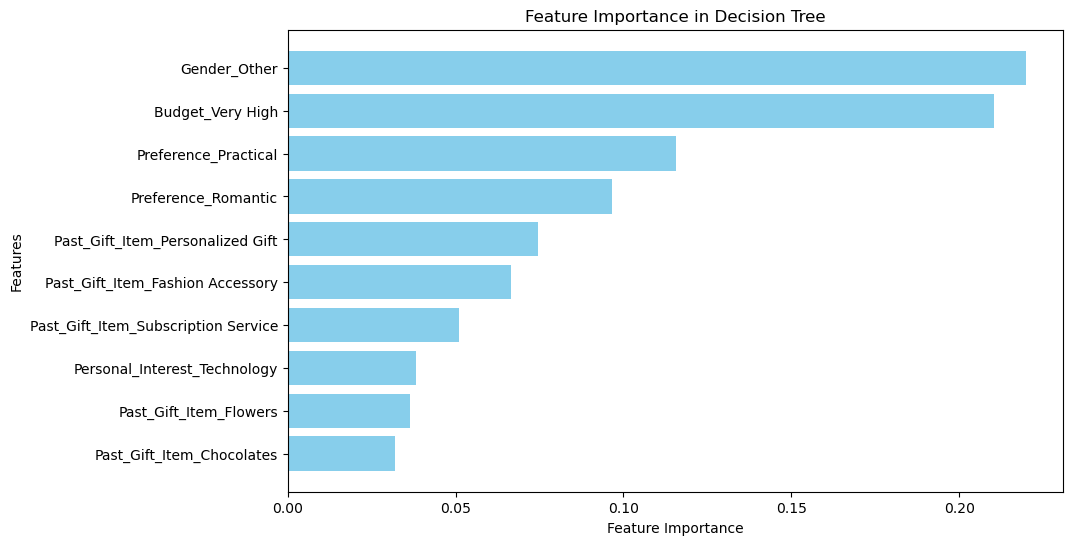

In [57]:
# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance in Decision Tree")
plt.gca().invert_yaxis()  # Flip to show most important features on top
plt.show()

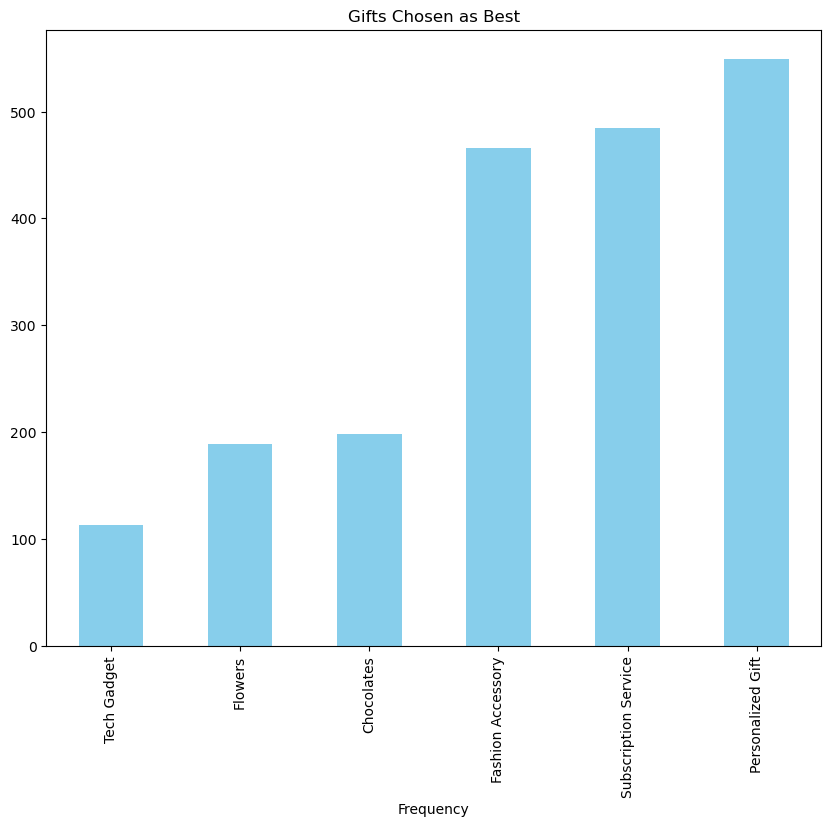

In [59]:
gift_counts = df['Best_Gift'].value_counts(ascending=True)

plt.figure(figsize=(10, 8))
gift_counts.plot(kind='bar', color='skyblue')  
plt.xlabel('Frequency')
plt.title('Gifts Chosen as Best')
plt.show()


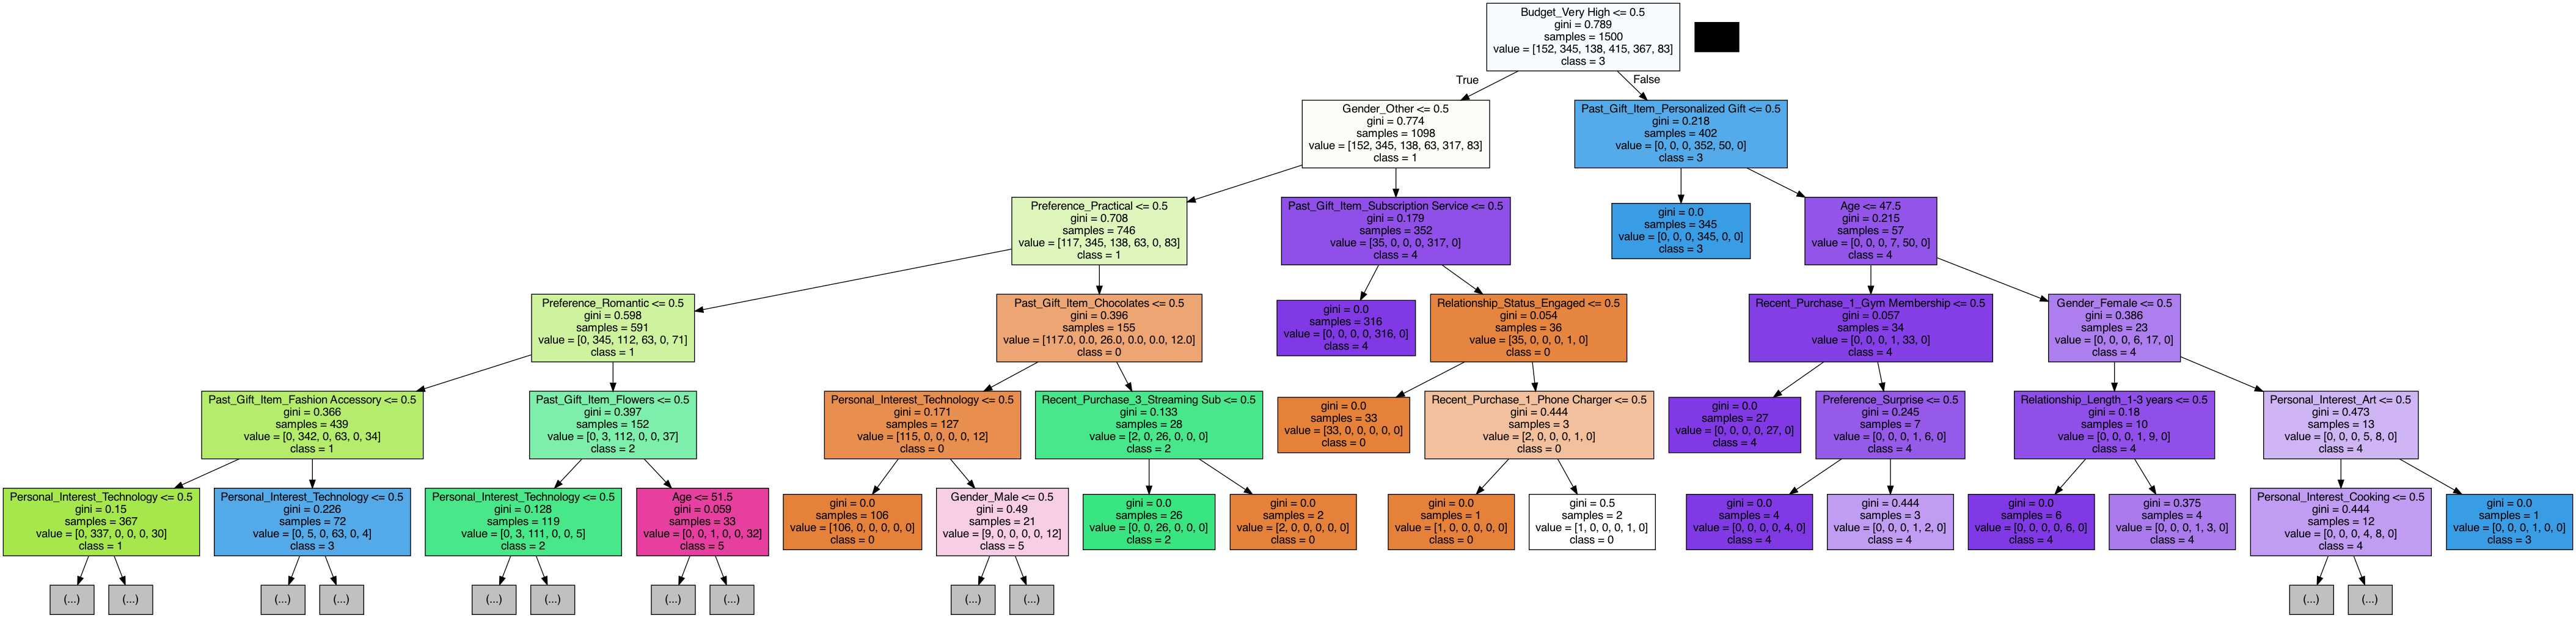

In [30]:
# DOT graphs
dot_data = export_graphviz(model, 
                                out_file=None,
                                feature_names=X.columns, 
                                class_names=["0", "1", "2", "3", "4", "5"], 
                                filled=True,
                                max_depth=5
                               )

graph = pydotplus.graph_from_dot_data(dot_data)

graph.write_pdf("gift_picker_decision.pdf")

Image(graph.create_png())

In [32]:
#Hyperparameter Tuning

# Sample dataset (replace with your actual dataset)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a DecisionTreeClassifier
model = DecisionTreeClassifier()

# Define the hyperparameter grid to search
param_grid = {
    'criterion': ['gini', 'entropy'],  # Measure to split nodes
    'max_depth': [3, 5, 10],  # Maximum depth of tree
    'min_samples_split': [2, 5, 10],  # Minimum samples to split a node
    'min_samples_leaf': [1, 2, 4]  # Minimum samples in a leaf node
}

# Set up GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

# Fit GridSearchCV to training data
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_

# Make predictions on test set
y_test_predict = best_model.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_test_predict)
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Test Set Accuracy: {accuracy:.4f}")


Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10}
Test Set Accuracy: 0.9950


In [33]:
#Print Model performance with hyperparameters
cv_results = pd.DataFrame(grid_search.cv_results_)
score_df = cv_results[['param_criterion', 'param_max_depth', 'param_min_samples_split', 
                       'param_min_samples_leaf', 'mean_test_score', 'rank_test_score']]
score_df = score_df.sort_values(by='rank_test_score')

score_df.head(5)


,param_criterion,param_max_depth,param_min_samples_split,param_min_samples_leaf,mean_test_score,rank_test_score
50,entropy,10,10,2,0.972500,1
20,gini,10,10,1,0.971875,2
46,entropy,10,5,1,0.971250,3
19,gini,10,5,1,0.971250,3
45,entropy,10,2,1,0.971250,5


In [35]:
X.corr()

,Age,Gender_Female,Gender_Male,Gender_Other,Relationship_Status_Dating,Relationship_Status_Engaged,Relationship_Status_Married,Relationship_Status_Single,Budget_High,Budget_Low,...,Recent_Purchase_3_Handbag,Recent_Purchase_3_Hat,Recent_Purchase_3_Headphones,Recent_Purchase_3_Magazine Sub,Recent_Purchase_3_Meal Kit Sub,Recent_Purchase_3_Necklace,Recent_Purchase_3_Phone Charger,Recent_Purchase_3_Processor Chip,Recent_Purchase_3_Smart Speaker,Recent_Purchase_3_Streaming Sub
Age,1.000000,0.020340,0.014349,-0.035494,0.017904,-0.075020,0.037618,0.023639,-0.023491,-0.004591,...,0.030954,-0.015509,-0.000076,-0.053640,0.005906,0.026469,0.026706,-0.028068,-0.027694,0.007112
Gender_Female,0.020340,1.000000,-0.524097,-0.473144,0.020014,-0.048293,-0.061646,0.089897,-0.014107,-0.045247,...,0.056706,0.034010,-0.028447,0.012702,0.006918,-0.002265,0.042187,0.019690,-0.085138,-0.011088
Gender_Male,0.014349,-0.524097,1.000000,-0.502325,-0.026508,0.061407,0.010589,-0.047744,0.035438,0.013016,...,-0.019675,-0.049846,-0.005744,-0.003108,0.027028,-0.006663,0.016182,-0.065433,0.085639,-0.047010
Gender_Other,-0.035494,-0.473144,-0.502325,1.000000,0.007101,-0.014490,0.051634,-0.041884,-0.022336,0.032475,...,-0.037221,0.017033,0.034824,-0.009682,-0.034982,0.009192,-0.059572,0.047695,-0.002148,0.059886
Relationship_Status_Dating,0.017904,0.020014,-0.026508,0.007101,1.000000,-0.348468,-0.304160,-0.324797,-0.002469,-0.014560,...,-0.026072,-0.036807,0.063051,-0.026191,-0.035284,0.025031,0.104475,-0.026329,-0.016918,0.016610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Recent_Purchase_3_Necklace,0.026469,-0.002265,-0.006663,0.009192,0.025031,-0.024774,-0.000166,0.001259,0.028888,-0.023461,...,-0.082249,-0.090789,-0.084294,-0.079567,-0.087723,1.000000,-0.092162,-0.096204,-0.076819,-0.095137
Recent_Purchase_3_Phone Charger,0.026706,0.042187,0.016182,-0.059572,0.104475,-0.000663,-0.072085,-0.031910,-0.034872,-0.027155,...,-0.091508,-0.101009,-0.093782,-0.088524,-0.097597,-0.092162,1.000000,-0.107034,-0.085466,-0.105846
Recent_Purchase_3_Processor Chip,-0.028068,0.019690,-0.065433,0.047695,-0.026329,-0.034724,0.079039,-0.014739,0.060953,0.036232,...,-0.095522,-0.105440,-0.097896,-0.092407,-0.101878,-0.096204,-0.107034,1.000000,-0.089215,-0.110489
Recent_Purchase_3_Smart Speaker,-0.027694,-0.085138,0.085639,-0.002148,-0.016918,0.065637,-0.054718,0.001620,-0.054602,-0.022764,...,-0.076274,-0.084193,-0.078170,-0.073786,-0.081349,-0.076819,-0.085466,-0.089215,1.000000,-0.088224


In [37]:
dg = X.copy()
dg['y'] = y

In [44]:
dg.drop(columns=['Gender_Female', 'Gender_Male', 'Gender_Other'], axis=1, inplace=True)

In [45]:
dg.corr()

,Age,Relationship_Status_Dating,Relationship_Status_Engaged,Relationship_Status_Married,Relationship_Status_Single,Budget_High,Budget_Low,Budget_Medium,Budget_Very High,Occasion_Anniversary,...,Recent_Purchase_3_Hat,Recent_Purchase_3_Headphones,Recent_Purchase_3_Magazine Sub,Recent_Purchase_3_Meal Kit Sub,Recent_Purchase_3_Necklace,Recent_Purchase_3_Phone Charger,Recent_Purchase_3_Processor Chip,Recent_Purchase_3_Smart Speaker,Recent_Purchase_3_Streaming Sub,y
Age,1.000000,0.017904,-0.075020,0.037618,0.023639,-0.023491,-0.004591,-0.024020,0.050461,-0.014497,...,-0.015509,-0.000076,-0.053640,0.005906,0.026469,0.026706,-0.028068,-0.027694,0.007112,-0.014825
Relationship_Status_Dating,0.017904,1.000000,-0.348468,-0.304160,-0.324797,-0.002469,-0.014560,0.006160,0.010142,0.025367,...,-0.036807,0.063051,-0.026191,-0.035284,0.025031,0.104475,-0.026329,-0.016918,0.016610,-0.004464
Relationship_Status_Engaged,-0.075020,-0.348468,1.000000,-0.340284,-0.363372,-0.056989,0.047065,-0.000938,0.013191,-0.032006,...,-0.022386,-0.005442,0.009400,0.025202,-0.024774,-0.000663,-0.034724,0.065637,0.002769,0.061425
Relationship_Status_Married,0.037618,-0.304160,-0.340284,1.000000,-0.317169,0.006881,0.030383,-0.007503,-0.027992,0.022999,...,0.060352,0.016843,0.020766,-0.016769,-0.000166,-0.072085,0.079039,-0.054718,-0.016424,-0.021247
Relationship_Status_Single,0.023639,-0.324797,-0.363372,-0.317169,1.000000,0.054656,-0.063750,0.002191,0.003497,-0.013986,...,0.000830,-0.072375,-0.004147,0.024703,0.001259,-0.031910,-0.014739,0.001620,-0.003246,-0.038569
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Recent_Purchase_3_Phone Charger,0.026706,0.104475,-0.000663,-0.072085,-0.031910,-0.034872,-0.027155,0.046200,0.015579,-0.024981,...,-0.101009,-0.093782,-0.088524,-0.097597,-0.092162,1.000000,-0.107034,-0.085466,-0.105846,0.039329
Recent_Purchase_3_Processor Chip,-0.028068,-0.026329,-0.034724,0.079039,-0.014739,0.060953,0.036232,-0.055096,-0.041290,0.012749,...,-0.105440,-0.097896,-0.092407,-0.101878,-0.096204,-0.107034,1.000000,-0.089215,-0.110489,0.053393
Recent_Purchase_3_Smart Speaker,-0.027694,-0.016918,0.065637,-0.054718,0.001620,-0.054602,-0.022764,0.066519,0.011510,-0.045212,...,-0.084193,-0.078170,-0.073786,-0.081349,-0.076819,-0.085466,-0.089215,1.000000,-0.088224,0.050507
Recent_Purchase_3_Streaming Sub,0.007112,0.016610,0.002769,-0.016424,-0.003246,0.012154,-0.072618,0.050397,0.007607,-0.003105,...,-0.104270,-0.096810,-0.091381,-0.100747,-0.095137,-0.105846,-0.110489,-0.088224,1.000000,0.018256


In [7]:
def getBestGiftForTeamNine():
    ourData = {'Gender': ['Male', 'Male','Male', 'Male', 'Female', 'Female'],
             'Age': [35, 20,38, 23, 32, 38], 
             'Relationship_Status': ['Single', 'Dating','Married', 'Single', 'Married','Married'], 
             'Budget': ['Medium', 'Low','Low', 'Very High', 'Low', 'High'], 
             'Occasion': ['Birthday', 'Just Because', 'Just Because', 'Just Because', 'Birthday','Just Because'], 
             'Preference': ['Practical', 'Practical', 'Romantic','Surprise','Surprise','Surprise'], 
             'Relationship_Length': ['<6 months', '<6 months', '5+ years','<6 months', '5+ years', '5+ years'], 
             'Personal_Interest': ['Technology', 'Music', 'Cooking','Music', 'Sports', 'Fashion'],
             'Past_Gift_Item': ['Chocolates', 'Tech Gadget', 'Flowers','Personalized Gift', 'Tech Gadget','Personalized Gift'],
             'Past_Gift_Reaction': ['Liked it', 'Loved it', 'Disliked it','Liked it', 'Loved it', 'Loved it'],
             'Recent_Purchase_1': ['Headphones', 'Streaming Sub', 'Meal Kit Sub','Phone Charger', 'Hat', 'Handbag'],
             'Recent_Purchase_2': ['Hat', 'Phone Charger', 'Streaming Sub','Hat', 'Smart Speaker', 'Necklace'],
             'Recent_Purchase_3': ['Streaming Sub', 'Headphones', 'Phone Charger','Streaming Sub', 'Headphones', 'Headphones']}
    
    names = ['Leslie', 'Leonard', 'Sophak', 'Gabe', 'Rakesh', 'Yujing']
    gifts = ['Chocolates', 'Fashion Accessory', 'Flowers', 'Personalized gift', 'Subscription Service', 'Tech Gadget']


    df = pd.DataFrame(ourData)
    X_our = hot_encode(df)

    model = DecisionTreeClassifier()

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=7)
    model.fit(X_train, y_train)


    missing_columns = [col for col in X_train.columns if col not in X_our.columns]
    missing_data = pd.DataFrame(0, index=X_our.index, columns=missing_columns)
    final_df = pd.concat([X_our, missing_data], axis=1)
    final_df = final_df.reindex(columns=X_train.columns)

    y_pred = model.predict(final_df)

    for index, name in enumerate(names):
        gift_num = y_pred[index]
        best_gift = gifts[gift_num]
        print(f'the best gift for {name} is {best_gift}')

In [8]:
getBestGiftForTeamNine()

the best gift for Leslie is Flowers
the best gift for Leonard is Chocolates
the best gift for Sophak is Tech Gadget
the best gift for Gabe is Subscription Service
the best gift for Rakesh is Fashion Accessory
the best gift for Yujing is Fashion Accessory
